# THE2 - CENG403 Spring 2024

This document contains the backbone structure for the take-home exam. You should complete this template for your solution.

# 1 The Gergen Library [THE1 Solution]

This section presents the code for solving THE1. You can modify any part as desired. The implementation of `rastgele_gercek`, `rastgele_dogal`, and `gergen` classes, as well as the necessary operations in the `Operation` class, are all provided.

## 1.1 Implementation for `rastgele_gercek` and `rastgele_dogal`

Uniform distribution is the only option available for `rastgele_dogal`. However, for `rastgele_gercek`, you can choose between uniform and gaussian distributions.

In [1]:
import random
import math
from typing import Union
import matplotlib.pyplot as plt

In [2]:
def cekirdek(sayi: int):
    # Sets the seed for random number generation
    random.seed(sayi)


def rastgele_dogal(boyut, aralik=None, dagilim='uniform'):
    """
    Generates data of specified dimensions with random integer values and returns a gergen object.

    Parameters:
        boyut (tuple): Shape of the desired data.
        aralik (tuple, optional): (min, max) specifying the range of random values. Defaults to None, which implies a default range.
        dagilim (string, optional): Distribution of random values ('uniform' or other types). Defaults to 'uniform'.

    Returns:
        gergen: A new gergen object with random integer values.
    """

    # Set a default range if aralik is not provided
    if aralik is None:
        aralik = (0, 10)

    def generate_random_data(shape):
        if len(shape) == 1:
            return [random_value(aralik, dagilim) for _ in range(shape[0])]
        else:
            return [generate_random_data(shape[1:]) for _ in range(shape[0])]

    def random_value(aralik, dagilim):
        if dagilim == 'uniform':
            return random.randint(*aralik)
        else:
            raise ValueError(f"Unsupported distribution: {dagilim}")

    data = generate_random_data(boyut)
    return gergen(data)


def rastgele_gercek(boyut, aralik=(0.0, 1.0), dagilim='uniform'):
    """
    Generates a gergen of specified dimensions with random floating-point values.

    Parameters:
        boyut (tuple): Shape of the desired gergen.
        aralik (tuple, optional): (min, max) specifying the range of random values. Defaults to (0.0, 1.0) for uniform distribution.
        dagilim (string, optional): Distribution of random value (e.g., 'uniform', 'gaussian'). Defaults to 'uniform'.

    Returns:
        gergen: A new gergen object with random floating-point values.
    """

    def generate_random_data(shape):
        if len(shape) == 1:
            return [random_value(aralik, dagilim) for _ in range(shape[0])]
        else:
            return [generate_random_data(shape[1:]) for _ in range(shape[0])]

    def random_value(aralik, dagilim):
        if dagilim == 'uniform':
            return random.uniform(*aralik)
        elif dagilim == 'gaussian':
            mean, std_dev = aralik
            return random.gauss(mean, std_dev)
        else:
            raise ValueError(f"Unsupported distribution: {dagilim}")

    data = generate_random_data(boyut)
    return gergen(data)

## 1.2 Operation Class Definition

You can find the latest version of the Operation class here.

In [3]:
class Operation:

    def __call__(self, *operands, **kwargs):
        """
        Calls the operation with the provided operands and keyword arguments.

        Parameters:
            *operands: Variable length operand list.
            **kwargs: Variable length keyword argument list.

        Returns:
            gergen: The result of the operation.
        """
        self.operands = operands
        self.kwargs = kwargs  # Store keyword arguments separately
        self.outputs = None
        return self.ileri(*operands, **kwargs)

    def ileri(self, *operands, **kwargs):
        """
        Defines the forward pass of the operation.
        Must be implemented by subclasses to perform the actual operation.

        Parameters:
            *operands: Variable length operand list.
            **kwargs: Variable length keyword argument list.

        Raises:
            NotImplementedError: If not overridden in a subclass.
        """
        raise NotImplementedError

    def geri(self, grad_input):
        """
        Defines the backward pass of the operation.
        Must be implemented by subclasses to compute the gradients.

        Parameters:
            grad_input: The gradient of the loss w.r.t. the output of this operation.
        """
        raise NotImplementedError

## 1.3 Implemented Operations
The section contains all implementations from THE1. You can customize any part as you like, and you need to complete the `TODO` sections.


### 1.3.1 Add

In [4]:
class Add(Operation):

    def ileri(self, a, b):
        """
        Adds two gergen objects or a gergen object and a scalar.
        
        Parameters:
            a (gergen or list): The first operand.
            b (gergen or list): The second operand.
        
        Returns:
            gergen: The result of the addition.
        """
        if isinstance(a, gergen) and isinstance(b, gergen):
            self.a = a
            self.b = b
            self.operands = [a, b]
            result = gergen(self.add_gergen(a.duzlestir().listeye(), b.duzlestir().listeye()), operation=self)
            result.boyutlandir(a.boyut())
        elif isinstance(a, gergen) and isinstance(b, (list)):
            self.a = a
            self.b = b
            self.operands = [a]
            result = gergen(self.add_list(a.listeye(), b), operation=self)
        elif isinstance(b, gergen) and isinstance(a, (list)):
            self.a = b
            self.b = a
            self.operands = [b]
            result = gergen(self.add_list(b.listeye(), a), operation=self)
        elif isinstance(a, gergen) and isinstance(b, (int, float)):
            self.a = a
            self.b = b
            self.operands = [a]
            result = gergen(self.add_scalar(a.listeye(), b), operation=self)
        elif isinstance(b, gergen) and isinstance(a, (int, float)):
            self.a = b
            self.b = a
            self.operands = [b]
            result = gergen(self.add_scalar(b.listeye(), a), operation=self)
        else:
            raise ValueError("Add operation requires at least one gergen operand.")

        result.requires_grad = True
        return result

    def add_scalar(self, a, scalar):
        if isinstance(a, list):
            return [self.add_scalar(elem, scalar) for elem in a]
        else:
            return a + scalar

    def add_gergen(self, a, b):
        # Check if 'a' is a list
        if isinstance(a, list):
            # Check if 'b' is a list
            if isinstance(b, list):
                if len(a) != len(b):
                    raise ValueError("Dimensions of gergen objects do not match for addition.")
                return [a[i] + b[i] for i in range(len(a))]
            # If 'a' is a list and 'b' is a scalar
            elif not isinstance(b, list):
                return [item + b for item in a]

        # If 'a' is a scalar and 'b' is a list
        elif not isinstance(a, list) and isinstance(b, list):
            return [a + item for item in b]
        # Direct addition for scalars, or fallback error for unsupported types
        elif not isinstance(a, list) and not isinstance(b, list):
            return a + b

    def add_list(self, a, b):
        # Check if 'a' is a list
        if isinstance(a, list) and isinstance(b, list):
            return [self.add_list(elem_a, elem_b) for elem_a, elem_b in zip(a, b)]
        # If 'a' is list and b is scalar
        elif isinstance(a, list) and not isinstance(b, list):
            return [self.add_list(elem_a, b) for elem_a in a]
        elif not isinstance(a, list) and isinstance(b, list):
            return [self.add_list(a, elem_b) for elem_b in b]
        elif not isinstance(a, list) and not isinstance(b, list):
            return a + b

    def geri(self, grad_input):
        # The gradient with respect to both inputs of addition is 1 if both gergen else the second is 0
        grad_a = grad_input
        grad_b = grad_input if isinstance(self.b, gergen) else 0
        result = (grad_a, grad_b)
        return result[:len(self.operands)] # Return derivatives only the number of operands

### 1.3.2 Sub

In [5]:
class Sub(Operation):

    def ileri(self, a, b):
        """
        Subtracts two gergen objects or a gergen object and a scalar.
        
        Parameters:
            a (gergen or list): The first operand.
            b (gergen or list): The second operand.
        
        Returns:
            gergen: The result of the subtraction.
        """
        if isinstance(a, gergen) and isinstance(b, gergen):
            self.a, self.b = a, b
            self.operands = [a, b]
            result = gergen(self.subtract_gergen(a.duzlestir().veri, b.duzlestir().veri), operation=self)
            result.boyutlandir(a.boyut())
        elif isinstance(a, gergen) and isinstance(b, (list)):
            self.a = a
            self.b = b
            self.operands = [a]
            result = gergen(self.subtract_list(a.veri, b), operation=self)
        elif isinstance(b, gergen) and isinstance(a, (list)):
            self.a = b
            self.b = a
            self.operands = [b]
            result = gergen(self.subtract_list(a, b.veri), operation=self)
        elif isinstance(a, gergen) and isinstance(b, (int, float)):
            self.a = a
            self.b = b
            self.operands = [a]
            result = gergen(self.subtract_scalar(a.veri, b), operation=self)
        elif isinstance(b, gergen) and isinstance(a, (int, float)):
            self.a = b
            self.b = a
            self.operands = [b]
            result = gergen(self.subtract_scalar(b.veri, a), operation=self)
        else:
            raise ValueError("Sub operation requires at least one gergen operand.")
        return result

    def subtract_scalar(self, a, scalar):
        if isinstance(a, list):
            return [self.subtract_scalar(elem, scalar) for elem in a]
        else:
            return a - scalar

    def subtract_list(self, a, b):
        # Check if 'b' is a list
        if isinstance(a, list) and isinstance(b, list):
            return [self.subtract_list(elem_a, elem_b) for elem_a, elem_b in zip(a, b)]
        # If 'a' is list and b is scalar
        elif isinstance(a, list) and not isinstance(b, list):
            return [self.subtract_list(elem_a, b) for elem_a in a]
        elif not isinstance(a, list) and isinstance(b, list):
            return [self.subtract_list(a, elem_b) for elem_b in b]
        elif not isinstance(a, list) and not isinstance(b, list):
            return a - b

    def subtract_gergen(self, a, b):
        # Check if 'a' is a list
        if isinstance(a, list):
            # Check if 'b' is a list
            if isinstance(b, list):
                if len(a) != len(b):
                    raise ValueError("Dimensions of gergen objects do not match for subtraction.")
                return [a[i] - b[i] for i in range(len(a))]
            # If 'a' is a list and 'b' is a scalar
            elif not isinstance(b, list):
                return [item - b for item in a]
        # If 'a' is a scalar and 'b' is a list
        elif not isinstance(a, list) and isinstance(b, list):
            return [a - item for item in b]
        # Direct subtraction for scalars, or fallback error for unsupported types
        elif not isinstance(a, list) and not isinstance(b, list):
            return a - b

    def geri(self, grad_input):
        # The gradient with respect to the first input is 1, and with respect to the second input is -1
        grad_a = grad_input
        grad_b = -grad_input if isinstance(self.b, gergen) else 0
        result = (grad_a, grad_b)
        return result[:len(self.operands)] # Return derivatives only the number of operands

### 1.3.3 TrueDiv

In [6]:
class TrueDiv(Operation):

    def ileri(self, a, b):
        """
        Divides two gergen objects or a gergen object and a scalar.
        
        Parameters:
            a (gergen or list): The first operand.
            b (gergen or list): The second operand.
        
        Returns:
            gergen: The result of the division.
        """
        if isinstance(a, gergen) and isinstance(b, gergen):
            self.a, self.b = a, b
            self.operands = [a, b]
            result = gergen(self.divide_elements(a.duzlestir().veri, b.duzlestir().veri), operation=self)
            result.boyutlandir(a.boyut())
        elif isinstance(a, gergen) and isinstance(b, (int, float)):
            self.a = a
            self.b = b
            self.operands = [a]
            result = gergen(self.divide_scalar(a.veri, b), operation=self)
        elif isinstance(b, gergen) and isinstance(a, (int, float)):
            # Division of a scalar by a gergen object is not typically defined,
            # but you can implement it based on your requirements.
            raise NotImplementedError("Division of a scalar by a gergen object is not implemented.")
        else:
            raise ValueError("TrueDiv operation requires at least one gergen operand.")

        return result

    def divide_scalar(self, a, scalar):
        if isinstance(a, list):
            return [self.divide_scalar(elem, scalar) for elem in a]
        else:
            if scalar == 0:
                raise ZeroDivisionError("Division by zero.")
            return a / scalar

    def divide_elements(self, a, b):
        # Both a and b are non-lists (scalars), perform direct division
        if not isinstance(a, list) and not isinstance(b, list):
            if b == 0:
                raise ZeroDivisionError("Division by zero.")
            return a / b
        # Both a and b are lists, perform element-wise division
        elif isinstance(a, list) and isinstance(b, list):
            if len(a) != len(b):
                raise ValueError("Dimensions of gergen objects do not match for division.")
            return [self.divide_elements(elem_a, elem_b) for elem_a, elem_b in zip(a, b)]
        # One of a or b is a list and the other is a scalar, divide each element of the list by the scalar
        elif isinstance(a, list):
            return [self.divide_elements(elem, b) for elem in a]
        else:
            raise NotImplementedError("Division of scalar by a list is not typically defined.")

    def geri(self, grad_input):
        """
        Computes the backward pass of the division operation.

        Parameters:
            grad_input: The gradient of the loss w.r.t the output of this operation.

        Returns:
            Tuple: Gradients w.r.t each operand.
        """
        a, b = self.a, self.b
        if isinstance(a, gergen) and isinstance(b, gergen):
            # Gradient w.r.t a is grad_input / b
            grad_a = grad_input / b  # Assuming grad_input is not a scalar
            # Gradient w.r.t b is -grad_input * a / (b ** 2)
            grad_b = (-grad_input * a) / (b.us(2))
            return grad_a, grad_b
        elif isinstance(a, gergen) and isinstance(b, (int, float)):
            # When b is a scalar, the gradient w.r.t a is grad_input / b
            grad_a = grad_input / b  # Assuming grad_input is not a scalar
            # There is no gradient w.r.t to a scalar in the context of training neural networks
            return grad_a
        else:
            raise NotImplementedError(
                "Backpropagation for the division of a scalar by a gergen object is not supported.")

### 1.3.4 Mul

In [7]:
class Mul(Operation):

    def ileri(self, a, b):
        """
        Multiplies two gergen objects or a gergen object and a scalar.
        
        Parameters:
            a (gergen or list): The first operand.
            b (gergen or list): The second operand.
        
        Returns:
            gergen: The result of the multiplication.
        """
        if isinstance(a, gergen) and isinstance(b, gergen):
            self.a, self.b = a, b
            self.operands = [a, b]
            # a is a scalar gergen
            if a.uzunluk() == 1:
                result = gergen(self.multiply_scalar(b.veri, a.veri), operation=self)
            # b is a scalar gergen
            elif b.uzunluk() == 1:
                result = gergen(self.multiply_scalar(a.veri, b.veri), operation=self)
            else:
                result = gergen(self.multiply_elements(a.duzlestir().veri,
                                                       b.duzlestir().veri),
                                operation=self)
                result.boyutlandir(a.boyut())
        elif isinstance(a, gergen) and isinstance(b, (int, float)):
            self.a = a
            self.b = b
            self.operands = [a]
            result = gergen(self.multiply_scalar(a.veri, b), operation=self)
        elif isinstance(b, gergen) and isinstance(a, (int, float)):
            self.a = b
            self.b = a
            self.operands = [b]
            result = gergen(self.multiply_scalar(b.veri, a), operation=self)
        else:
            raise ValueError("Mul operation requires at least one gergen operand.")

        result.requires_grad = True
        return result

    def multiply_scalar(self, a, scalar):
        if isinstance(a, list):
            return [self.multiply_scalar(elem, scalar) for elem in a]
        else:
            return a * scalar

    def multiply_elements(self, a, b):
        # Both a and b are non-lists (scalars), perform direct multiplication
        if not isinstance(a, list) and not isinstance(b, list):
            return a * b
        # Both a and b are lists, perform element-wise multiplication
        elif isinstance(a, list) and isinstance(b, list):
            if len(a) != len(b):
                raise ValueError("Dimensions of gergen objects do not match for multiplication.")
            return [self.multiply_elements(elem_a, elem_b) for elem_a, elem_b in zip(a, b)]
        # One of a or b is a list and the other is a scalar, multiply each element of the list by the scalar
        elif isinstance(a, list):
            return [self.multiply_elements(elem, b) for elem in a]
        else:
            return [self.multiply_elements(a, elem) for elem in b]

    def geri(self, grad_input):
        """
        Computes the backward pass of the multiplication operation.

        Parameters:
            grad_input: The gradient of the loss w.r.t the output of this operation.

        Returns:
            Tuple: Gradients w.r.t each operand.
        """
        a, b = self.a, self.b
        grad_a = grad_input * b
        grad_b = grad_input * a if isinstance(b, gergen) else 0
        result = (grad_a, grad_b)
        return result[:len(self.operands)]

### 1.3.5 Us

In [8]:
class Us(Operation):

    def ileri(self, a, n):
        """
        Power operation.
        
        Parameters:
            a (gergen): The base.
            n (int): The exponent.
        
        Returns:
            gergen: The result of the power operation.
        """
        self.a = a
        self.n = n
        self.operands = [a]
        result = gergen(self.power_elements(a.veri, n), operation=self)
        return result

    def power_elements(self, a, n):
        if isinstance(a, list):
            return [self.power_elements(elem, n) for elem in a]
        else:
            return a**n

    def multiply_elements(self, a, b):
        # Both a and b are non-lists (scalars), perform direct multiplication
        if not isinstance(a, list) and not isinstance(b, list):
            return a * b
        # Both a and b are lists, perform element-wise multiplication
        elif isinstance(a, list) and isinstance(b, list):
            if len(a) != len(b):
                raise ValueError("Dimensions of gergen objects do not match for multiplication.")
            return [self.multiply_elements(elem_a, elem_b) for elem_a, elem_b in zip(a, b)]
        # One of a or b is a list and the other is a scalar, multiply each element of the list by the scalar
        elif isinstance(a, list):
            return [self.multiply_elements(elem, b) for elem in a]
        else:
            return [self.multiply_elements(a, elem) for elem in b]

    def geri(self, grad_input):
        """
        Computes the backward pass of the power operation.

        Parameters:
            grad_input: The gradient of the loss w.r.t the output of this operation.

        Returns:
            Tuple: Gradients w.r.t each operand.
        """
        a, n = self.a, self.n
        grad_a = grad_input * n * (a.us(n - 1))
        return grad_a

### 1.3.6 Log10

In [9]:
class Log10(Operation):

    def ileri(self, a):
        """
        Log10 operation

        Parameters:
            a (gergen): The input gergen object.

        Returns:
            gergen: The result of the log10 operation.
        """
        self.a = a
        self.operands = [a]
        # Recursively check for non-positive values in the nested list structure
        if self.contains_non_positive(self.a.veri):
            raise ValueError("Logarithm undefined for non-positive values.")
        result = gergen(self.log_elements(a.veri), operation=self)
        return result

    def log_elements(self, a):
        # Recursively apply the base 10 logarithm to each element
        if isinstance(a, list):
            return [self.log_elements(elem) for elem in a]
        else:
            return math.log10(a)

    def contains_non_positive(self, a):
        # Recursively check for non-positive values and flatten the results
        def check_and_flatten(a):
            flag = False
            if isinstance(a, list):
                # Use a generator expression to recursively check each element and flatten the result
                for ele in a:
                    flag = check_and_flatten(ele)
            else:
                if a <= 0:
                    return True
            return flag

        # Use 'any' on a flattened generator of boolean values
        return check_and_flatten(a)

    def multiply_elements(self, a, scalar):
        # Recursively multiply each element by the scalar
        if isinstance(a, list):
            return [self.multiply_elements(elem, scalar) for elem in a]
        else:
            return a * scalar

    def divide_elements(self, grad_output, b):
        # Recursively divide grad_output by b, assuming they have the same structure
        if isinstance(b, list):
            return [self.divide_elements(elem_grad, elem_b) for elem_grad, elem_b in zip(grad_output, b)]
        else:
            return grad_output / b

    def geri(self, grad_input):
        """
        Computes the backward pass of the Log10 operation.

        Parameters:
            grad_input: The gradient of the loss w.r.t the output of this operation.

        Returns:
            gergen: The gradient of the loss w.r.t the input of this operation.
        """
        a = self.a
        # Calculate the gradient w.r.t a using the properties of logarithmic differentiation
        # Gradient w.r.t a is: grad_input * (1 / (a * ln(10)))
        ln10 = math.log(10)
        grad_a = grad_input * (1 / (a * ln10))
        return grad_a

### 1.3.7 Ln

In [10]:
class Ln(Operation):

    def ileri(self, a):
        """
        Implements the forward pass for the Ln operation.
        
        Parameters:
            a (gergen): The input gergen object.

        Returns:
            gergen: The result of the natural logarithm operation.
        """
        if not isinstance(a, gergen):
            raise ValueError("Ln operation requires a gergen operand.")
        self.a = a
        self.operands = [a]
        if self.contains_non_positive(self.a.listeye()):
            raise ValueError("Logarithm undefined for non-positive values.")

        result = gergen(self.log_elements(a.listeye()), operation=self)
        return result

    def log_elements(self, a):
        # Recursively apply the base 10 logarithm to each element
        if isinstance(a, list):
            return [self.log_elements(elem) for elem in a]
        else:
            return math.log(a) if a > 0 else math.log(a + 10**-4)

    def contains_non_positive(self, a):
        # Recursively check for non-positive values
        def check_and_flatten(a):
            if isinstance(a, list):
                return any(check_and_flatten(elem) for elem in a)
            else:
                if a <= 0:
                    a = 1
                    return True
                else:
                    return False

        # Use 'any' on a flattened generator of boolean values
        return check_and_flatten(a)

    def geri(self, grad_input):
        """
        Computes the backward pass of the Ln operation.

        Parameters:
            grad_input: The gradient of the loss w.r.t the output of this operation.

        Returns:
            gergen: The gradient of the loss w.r.t the input of this operation.
        """
        a = self.a
        # Calculate the gradient w.r.t a using the properties of logarithmic differentiation
        # Gradient w.r.t a is: grad_input * (1 / a)
        grad_a = grad_input / a
        return grad_a

### 1.3.8 Sin, Cos, Tan

In [11]:
def apply_elementwise(g, func):
    """
    Applies a given function element-wise to the data in a gergen object.
    This version is capable of handling nested lists of any depth.

    Parameters:
        g (gergen): The input gergen object.
        func (function): The function to apply to the data.
    
    Returns:
        list: A new veri for a gergen object with the function applied element-wise.
    """

    def recursive_apply(data):
        if isinstance(data, list):
            # Recursively apply func to each element if data is a list
            return [recursive_apply(sublist) for sublist in data]
        else:
            # Apply func directly if data is a scalar (non-list)
            return func(data)

    # Use the recursive function to apply the operation to the gergen object's data
    return recursive_apply(g.listeye())


class Sin(Operation):

    def ileri(self, a):
        """
        Implements the forward pass for the Sin operation.
        
        Parameters:
            a (gergen): The input gergen object.

        Returns:
            gergen: The result of the sine operation.
        """
        self.operands = [a]
        result = gergen(apply_elementwise(a, math.sin), operation=self)
        return result

    def geri(self, grad_output):
        """
        Computes the backward pass of the Sin operation.
        """
        a = self.operands[0]
        # The gradient with respect to a is grad_output multiplied by the derivative of sin(a), which is cos(a).
        cos_a = apply_elementwise(a, math.cos)
        grad_a = grad_output * cos_a
        return grad_a


class Cos(Operation):

    def ileri(self, a):
        """
        Implements the forward pass for the Cos operation.
        
        Parameters:
            a (gergen): The input gergen object.

        Returns:
            gergen: The result of the cosine operation.
        """
        self.operands = [a]
        result = gergen(apply_elementwise(a, math.cos), operation=self)
        return result

    def geri(self, grad_output):
        """
        Computes the backward pass of the Cos operation.
        """
        a = self.operands[0]
        # The gradient with respect to a is grad_output multiplied by the derivative of cos(a), which is -sin(a).
        sin_a = apply_elementwise(a, math.sin)
        grad_a = grad_output * -sin_a
        return grad_a


class Tan(Operation):

    def ileri(self, a):
        """
        Implements the forward pass for the Tan operation.
        
        Parameters:
            a (gergen): The input gergen object.

        Returns:
            gergen: The result of the tangent operation.
        """
        self.operands = [a]
        result = gergen(apply_elementwise(a, math.tan), operation=self)
        return result

    def geri(self, grad_output):
        """
        Computes the backward pass of the Tan operation.
        """
        a = self.operands[0]
        # The gradient with respect to a is grad_output multiplied by the derivative of tan(a), which is sec^2(a).
        sec2_a = apply_elementwise(a, lambda x: 1 / math.cos(x)**2)
        grad_a = grad_output * sec2_a
        return grad_a

### 1.3.9 Topla

In [12]:
class Topla(Operation):

    def ileri(self, a, eksen=None):
        """
        Forward pass for the Topla operation.
        
        Parameters:
            a (gergen): The input gergen object.
            eksen (int, optional): The axis along which to sum the elements. Defaults to None.
        
        Returns:
            gergen: The result of the sum operation.
        """

        def sum_elements(lst):
            if isinstance(lst[0], list):
                return [sum_elements(sublst) for sublst in zip(*lst)]
            else:
                return sum(lst)

        def sum_along_axis(data, axis):
            if axis == 0:
                return sum_elements(data)
            else:
                return [sum_along_axis(subdata, axis - 1) for subdata in data]

        self.operands = [a]
        self.eksen = eksen
        if eksen is None:
            result = sum(a.duzlestir().listeye())
        elif isinstance(eksen, int):
            if eksen < 0 or eksen >= len(a.boyut()):
                raise ValueError("Axis out of bounds for gergen's dimensionality")
            result = sum_along_axis(a.listeye(), eksen)
        else:
            raise TypeError("Axis must be an integer or None")

        return gergen(result, operation=self)

    def geri(self, grad_output):
        """
        (Optional, not tested) Computes the backward pass of the Topla operation.
        """
        a = self.operands[0]
        if self.eksen is None:
            # If the sum was across the entire tensor, every element contributes equally.
            grad_input_shape = [1] * len(a.boyut())  # Create a shape of ones
            expanded_grad = grad_output.boyutlandir(grad_input_shape)  # Expand grad to match input shape
            grad_input = expanded_grad * gergen.custom_zeros(a.boyut())  # Multiply by a tensor of ones
        else:
            # If sum was along a particular axis, replicate the gradient along that axis
            repeats = [1] * len(a.boyut())
            repeats[self.eksen] = a.boyut()[self.eksen]
            grad_input = grad_output.repeat(repeats)

        return grad_input

### 1.3.10 Ortalama

In [13]:
class Ortalama(Operation):

    def ileri(self, a, eksen=None):
        """
        Forward pass for the Ortalama operation.

        Parameters:
            a (gergen): The input gergen object.
            eksen (int, optional): The axis along which to compute the average. Defaults to None.

        Returns:
            gergen: The result of the average operation.
        """

        def average_elements(total_sum, total_elements):
            # Compute the average
            if isinstance(total_sum, list):
                # If total_sum is a list (multi-dimensional case), calculate the average for each sublist
                return [average_elements(ts, total_elements) for ts in total_sum]
            else:
                # For a single number, just divide
                return total_sum / total_elements

        self.operands = [a]
        self.eksen = eksen
        sum_op = Topla()  # Instantiate the Sum operation

        total_sum = sum_op.ileri(a, eksen=eksen).listeye()

        if eksen is None:
            total_elements = a.uzunluk()
        else:
            if eksen < 0 or eksen >= len(a.boyut()):
                raise ValueError("Axis out of bounds for gergen's dimensionality")
            total_elements = a.boyut()[eksen]

        # Compute the average
        average_result = average_elements(total_sum, total_elements)
        return gergen(average_result, operation=self)

    def geri(self, grad_output):
        """
        Computes the backward pass of the Ortalama operation. ?????
        """
        a = self.operands[0]

        # Calculate the number of elements involved in the averaging operation.
        if self.eksen is None:
            # Average over all elements
            total_elements = a.uzunluk()
        else:
            # Average over a specific axis
            total_elements = a.boyut()[len(a.boyut()) - self.eksen - 1]

        # The gradient of the average is the incoming gradient divided by the number of elements.
        # This division gives us the gradient per element that was averaged.
        # We then need to create a tensor with this gradient for each element that was part of the average.

        # First, create a gergen object with the same shape as 'a', filled with 1/total_elements
        grad_per_element = gergen(1 / total_elements)

        # Then, we'll broadcast this gradient to the shape of 'a' to distribute it across all elements.
        # Multiplication with the broadcasted gradient tensor gives us the gradient with respect to the input 'a'.
        grad_a = grad_output * grad_per_element

        return grad_a

### 1.3.11 IcCarpim

In [14]:
class IcCarpim(Operation):

    def ileri(self, a, b):
        """
        Computes the dot product of two gergen objects.

        Parameters:
            a (gergen): The first operand.
            b (gergen): The second operand.

        Returns:
            gergen: The result of the dot product operation.
        """
        self.a = a
        self.b = b
        self.operands = [a, b]
        if not isinstance(a, type(b)):
            raise ValueError("Both operands must be gergen objects.")

        def is_vector(v):
            return len(v.boyut()) == 1

        def is_matrix(m):
            return len(m.boyut()) == 2

        def vector_dot_product(v1, v2):
            if len(v1) != len(v2):
                raise ValueError("Vectors must have the same length for dot product.")
            return sum(x * y for x, y in zip(v1, v2))

        def matrix_multiply(m1, m2):
            if len(m1[0]) != len(m2):
                raise ValueError(
                    "The number of columns in the first matrix must match the number of rows in the second matrix."
                )
            return [[sum(a * b for a, b in zip(row_a, col_b)) for col_b in zip(*m2)] for row_a in m1]

        if len(a.boyut()) > 2 or len(b.boyut()) > 2:
            raise ValueError("Operands must both be either 1-D vectors or 2-D matrices.")
        elif is_vector(a) and is_vector(b):
            # Perform vector dot product
            result = vector_dot_product(a.listeye(), b.listeye())
        elif is_matrix(a) and is_matrix(b):
            # Perform matrix multiplication
            result = matrix_multiply(a.listeye(), b.listeye())
        else:
            raise ValueError("Operands must both be either 1-D vectors or 2-D matrices.")

        # Return result
        return gergen(result, operation=self, requires_grad=True)

    def geri(self, grad_output):
        """
        Computes the backward pass of the IcCarpim operation.

        Parameters:
            grad_output: The gradient of the loss w.r.t the output of this operation.
        
        Returns:
            Tuple: Gradients w.r.t each operand.
        """
        a = self.operands[0]
        b = self.operands[1]

        # Ensure the gradient output is a gergen object
        if not isinstance(grad_output, gergen):
            grad_output = gergen(grad_output)

        # Compute gradients with respect to inputs
        if len(a.boyut()) == 2 and len(b.boyut()) == 2:
            # Matrix multiplication case
            grad_a = grad_output.ic_carpim(b.devrik())  # grad_output (m x p) * b^T (p x n) => (m x n)
            grad_b = a.devrik().ic_carpim(grad_output)  # a^T (n x m) * grad_output (m x p) => (n x p)
        else:
            raise ValueError(
                "Operands and gradient outputs must both be 2-D matrices for matrix multiplication.")

        return grad_a, grad_b

### 1.3.12 DisCarpim

In [15]:
class DisCarpim(Operation):

    def ileri(self, a, b):
        """
        Computes the outer product of two gergen objects.

        Parameters:
            a (gergen): The first operand.
            b (gergen): The second operand.

        Returns:
            gergen: The result of the outer product operation.
        """
        if not isinstance(a, gergen) or not isinstance(b, gergen):
            raise ValueError("Both operands must be gergen objects.")

        # Ensure the veri attributes are lists representing vectors
        if not all(isinstance(x, (int, float))
                   for x in a.listeye()) or not all(isinstance(y, (int, float)) for y in b.listeye()):
            raise ValueError("Both gergen objects must contain 1-D numerical data.")

        self.operands = [a, b]
        # Compute the outer product
        result = [[x * y for y in b.listeye()] for x in a.listeye()]

        # Return a new gergen object with the outer product as its veri
        return gergen(result, operation=self)

    def geri(self, grad_input):
        """
        Computes the backward pass of the DisCarpim operation.
        """
        a = self.operands[0]
        b = self.operands[1]

        # Gradients for a are the dot product of grad_input with each column of b
        # grad_input.shape = (len(a.veri), len(b.veri))
        # We sum over the columns of grad_input for each element in b
        grad_a = [
            sum(grad_input.veri[i][j] * b.veri[j] for j in range(len(b.veri))) for i in range(len(a.veri))
        ]

        # Gradients for b are the dot product of grad_input with each row of a
        # We sum over the rows of grad_input for each element in a
        grad_b = [
            sum(grad_input.veri[i][j] * a.veri[i] for i in range(len(a.veri))) for j in range(len(b.veri))
        ]

        # Return gradients wrapped in gergen objects
        return gergen(grad_a, operation=self), gergen(grad_b, operation=self)

### 1.3.13 Gergen Class

In [16]:
class gergen:
    __veri = None  # A nested list of numbers representing the data
    D = None  # Transpose of data
    turev = None  # Stores the derivate
    operation = None  # Stores the operation that produced the gergen
    __boyut = None  # Dimensions of the gergen (Shape)
    requires_grad = True  # Flag to determine if the gradient should be computed

    def __init__(self, veri=None, operation=None, requires_grad=True):
        # The constructor for the 'gergen' class.
        if veri is None:
            self.__veri = []
            self.__boyut = (0,)
            self.D = None
            self.turev = None
            self.operation = operation
            self.requires_grad = requires_grad
        else:
            self.__veri = veri
            self.__boyut = self.get_shape(veri, ())  # Assuming rectangular data
            self.D = None
            self.turev = None
            self.operation = operation
            self.requires_grad = requires_grad

    def __iter__(self):
        # The __iter__ method returns the iterator object itself.
        # You can reset the iterator here if you want to allow multiple passes over the data.

        # Reset the iterator
        self.__current = 0
        return self

    def __next__(self):
        # The __next__ method should return the next value from the iterator.

        # Check if we've reached the end of the list
        if self.__current < len(self.__veri):
            result = self.__veri[self.__current]
            self.__current += 1
            return result

    def __getitem__(self, key):
        """
        Allows for indexing or slicing the gergen object's data.

        Parameters:
            key (int, slice, tuple): An integer or slice for one-dimensional indexing,
                                     or a tuple for multi-dimensional indexing/slicing.

        Returns:
            The element or a new gergen object corresponding to the provided key.
        """

        # Helper function to handle recursive indexing/slicing
        def index_or_slice(data, key):
            if isinstance(key, int) or isinstance(key, slice):
                return data[key]
            elif isinstance(key, tuple):
                result = data
                for k in key:
                    result = index_or_slice(result, k)
                return result
            else:
                raise TypeError(f"Invalid index type: {type(key)}")

        # Perform the indexing or slicing operation
        result = index_or_slice(self.__veri, key)
        # If the result is a list, return it wrapped in a new gergen object
        return gergen(result)

    def __str__(self):
        # Generates a string representation
        if self.uzunluk() == 0:
            return "Empty Gergen"
        else:
            shape_str = ""
            for b in self.boyut():
                shape_str += str(b) + "x"
            if shape_str == "":
                shape_str += "0x"
            return shape_str[:-1] + " boyutlu gergen:" + "\n" + self.str_helper(
                self.listeye(), len(self.boyut()))

    def str_helper(self, data, shape, depth=0):
        if not shape:
            return str(data)
        elif not isinstance(data[0], list):
            return str(data)
        else:
            inner_results = []
            for subdata in data:
                inner_results.append(self.str_helper(subdata, shape, depth + 1))

            result = "[" + ("\n" * (shape - depth - 1)).join(r for r in inner_results) + "]"
            return result

    @property
    def veri(self):
        return self.__veri

    @staticmethod
    def get_shape(lst, shape=()):
        if not isinstance(lst, list):
            # base case
            return shape
        # peek ahead and assure all lists in the next depth
        # have the same length
        if isinstance(lst[0], list):
            l = len(lst[0])
            if not all(len(item) == l for item in lst):
                msg = 'not all lists have the same length'
                raise ValueError(msg)

        shape += (len(lst),)
        # recurse
        shape = gergen.get_shape(lst[0], shape)

        return shape

    @staticmethod
    def custom_zeros(shape):
        """
        Creates a multi-dimensional array of zeros with the specified shape.

        Parameters:
            shape (tuple): A tuple representing the dimensions of the array.

        Returns:
            A nested list (multi-dimensional gergen) filled with zeros.
        """
        if not shape:  # If shape is empty or reaches the end of recursion
            return 0
        # Recursively build nested lists
        return [gergen.custom_zeros(shape[1:]) for _ in range(shape[0])]

    # HELPER
    @staticmethod
    def prod(iterable):
        """
        Utility function to calculate the product of elements in an iterable.
        """
        result = 1
        for i in iterable:
            result *= i
        return result

    def __mul__(self, other: Union['gergen', int, float]) -> 'gergen':
        mul_operation = Mul()
        result_gergen = mul_operation(self, other)
        return result_gergen

    def __rmul__(self, other: Union['gergen', int, float]) -> 'gergen':
        mul_operation = Mul()
        result_gergen = mul_operation(self, other)
        return result_gergen

    def __truediv__(self, other: Union['gergen', int, float]) -> 'gergen':
        div_operation = TrueDiv()
        result_gergen = div_operation(self, other)
        return result_gergen

    def __rtruediv__(self, other: Union['gergen', int, float]) -> 'gergen':
        div_operation = TrueDiv()
        result_gergen = div_operation(self, other)
        return result_gergen

    def __add__(self, other):
        add_operation = Add()
        result_gergen = add_operation(self, other)
        return result_gergen

    def __radd__(self, other):
        add_operation = Add()
        result_gergen = add_operation(self, other)
        return result_gergen

    def __sub__(self, other):
        sub_operation = Sub()
        result_gergen = sub_operation(self, other)
        return result_gergen

    def __rsub__(self, other):
        sub_operation = Sub()
        result_gergen = sub_operation(other, self)
        return result_gergen

    def uzunluk(self):
        # Returns the total number of elements in the gergen
        total = 1
        for ele in self.__boyut:
            total *= ele
        return total

    def boyut(self):
        # Returns the shape of the gergen
        return self.__boyut

    def devrik(self):
        """
        Returns the transpose of the gergen object.

        Returns:
            gergen: The transpose of the gergen object.
        """
        if self.uzunluk() == 1:
            return gergen(self.__veri)
        # Check if the gergen object represents a 1D list (vector)
        if isinstance(self.__veri, list) and all(not isinstance(item, list) for item in self.__veri):
            # Convert each element into a list (column vector)
            return gergen([[item] for item in self.__veri])
        else:
            # Handle higher-dimensional cases (e.g., 2D matrices, 3D tensors, etc.)
            new_boyut = tuple(reversed(self.__boyut))
            order = list(reversed(range(len(self.__boyut))))
            arr = self.custom_zeros(
                new_boyut)  # Assuming custom_zeros initializes an array with the given shape
            paths = [0] * len(self.__boyut)
            while paths[0] < self.__boyut[0]:
                ref = self.listeye()
                place = arr
                for i in range(len(paths) - 1):
                    ref = ref[paths[i]]
                    place = place[paths[order[i]]]

                place[paths[order[-1]]] = ref[paths[-1]]
                paths[-1] += 1
                for i in range(len(paths) - 1, 0, -1):
                    if paths[i] >= self.__boyut[i]:
                        paths[i] = 0
                        paths[i - 1] += 1
                    else:
                        break
            self.D = gergen(arr)
            return gergen(arr)

    def L1(self):
        # Calculates and returns the L1 norm
        flattened_data = self.duzlestir().__veri  # Assuming flatten returns a gergen object
        # Calculate the L1 norm by summing the absolute values of elements in the flattened list
        l1_norm = sum(abs(item) for item in flattened_data)
        return l1_norm

    def L2(self):
        # Assuming flatten returns a gergen object and __veri holds the flattened data
        flattened_data = self.duzlestir().__veri
        # Calculate the L2 norm by summing the squares of elements in the flattened list and then taking the square root
        l2_norm = sum(item**2 for item in flattened_data)**0.5
        return l2_norm

    def Lp(self, p):
        # Calculates and returns the Lp norm, where p should be positive integer
        if p <= 0:
            raise ValueError("p must be a positive integer for Lp norm.")
        # Assuming flatten returns a gergen object and __veri holds the flattened data
        flattened_data = self.duzlestir().__veri

        # Calculate the Lp norm by raising elements to the power of p, summing, and then taking the p-th root
        lp_norm = sum(abs(item)**p for item in flattened_data)**(1 / p)

        return lp_norm

    def listeye(self):
        # Converts the gergen object into a list or a nested list, depending on its dimensions.
        if isinstance(self.__veri, list):
            if not self.__veri:
                return []
            return self.__veri.copy()
        else:
            return self.__veri

    def duzlestir(self):
        """
        Flattens a multidimensional list (self.__veri) into a 1D list.

        Returns:
            gergen: A new gergen object with the flattened list.
        """
        if not isinstance(self.__veri, list):
            return gergen(self.__veri)
        flattened_list = []
        # Create a stack with the initial list
        stack = [self.__veri]

        # Process the stack
        while stack:
            current_item = stack.pop()
            if isinstance(current_item, list):
                # Extend the stack by reversing the current item list
                # to maintain the original order in the flattened list
                stack.extend(current_item[::-1])
            else:
                # If it's not a list, add it to the flattened list
                flattened_list.append(current_item)

        # Since we're appending elements to the end, but processing the stack in LIFO order,
        # we need to reverse the flattened list to restore the original element order
        flattened_list.reverse()

        # Create a new gergen instance with the flattened list
        return gergen(flattened_list)

    def boyutlandir(self, yeni_boyut):
        """
        Reshapes the gergen object to a new shape 'yeni_boyut', specified as a tuple.
        """
        # Flatten the data first
        flat_data = list(self.duzlestir().__veri)

        def reshape_helper(data, dims):
            if not dims:
                return data.pop(0)
            return [reshape_helper(data, dims[1:]) for _ in range(dims[0])]

        # Check if the new shape is compatible with the number of elements
        if self.prod(yeni_boyut) != len(flat_data):
            raise ValueError("New shape must have the same number of elements as the original.")

        # Use the helper to create the reshaped data and update the object's internal state
        self.__veri = reshape_helper(flat_data, yeni_boyut)
        self.__boyut = yeni_boyut

    def ic_carpim(self, other):
        ic_carpim_operation = IcCarpim()
        result_gergen = ic_carpim_operation(self, other)
        return result_gergen

    def dis_carpim(self, other):
        dis_carpim_operation = DisCarpim()
        result_gergen = dis_carpim_operation(self, other)
        return result_gergen

    def us(self, n):
        # Applies the power function to each element of the gergen object.
        power_operation = Us()
        result_gergen = power_operation(self, n)
        return result_gergen

    def log(self):
        # Applies the log function to each element of the gergen object.
        log_operation = Log10()
        result_gergen = log_operation(self)
        return result_gergen

    def ln(self):
        # Applies the ln function to each element of the gergen object.
        log_operation = Ln()
        result_gergen = log_operation(self)
        return result_gergen

    def sin(self):
        # Applies the sin function to each element of the gergen object.
        sin_operation = Sin()
        result_gergen = sin_operation(self)
        return result_gergen

    def cos(self):
        # Applies the cos function to each element of the gergen object.
        cos_operation = Cos()
        result_gergen = cos_operation(self)
        return result_gergen

    def tan(self):
        # Applies the tan function to each element of the gergen object.
        tan_operation = Tan()
        result_gergen = tan_operation(self)
        return result_gergen

    def topla(self, eksen=None):
        # Calculates the sum of the elements of the gergen object, optionally along a specified axis 'eksen'.
        topla_operation = Topla()
        result_gergen = topla_operation(self, eksen=eksen)
        return result_gergen

    def ortalama(self, eksen=None):
        # Calculates the average of the elements of the gergen object, optionally along a specified axis 'eksen'.
        ortalama_operation = Ortalama()
        result = ortalama_operation(self, eksen=eksen)
        return result

    def turev_al(self, grad_output=1):
        """
        Computes the backward pass of the operation that produced this gergen object.

        Parameters:
            grad_output: The gradient of the loss w.r.t the output of the operation.

        Returns:
            None: Gradients are propagated recursively.
        """
        self.turev = grad_output

        if self.operation == None:
            return grad_output
        elif type(self.operation) == Add or type(self.operation) == IcCarpim:
            g1, g2 = self.operation.geri(self.turev)
            self.operation.operands[0].turev_al(g1)
            self.operation.operands[1].turev_al(g2)
        elif type(self.operation) == ReLU or type(self.operation) == Softmax:
            g1 = self.operation.geri(self.turev)
            self.operation.x.turev_al(g1)
        elif len(self.operation.operands) == 1:
            # Typically it should not be entering here, maybe for division
            self.operation.operands[0].turev_al(grad_output)
        elif len(self.operation.operands) == 2:
            # Typically it should not be entering here
            self.operation.operands[0].turev_al(grad_output)
            self.operation.operands[1].turev_al(grad_output)
        else:
            raise NotImplementedError("Operation not implemented yet" + str(self.operation))
        self.operation = None


# 2 The MLP Implementation

Now, you need to complete the MLP implementation. Your task is to complete the MLP implementation by following the steps outlined.

## 2.1 Katman Class

To complete MLP implementation, we first need to implement Katman (Layer) class. Implementing the Katman class involves defining its structure and operational methods such as the necessary mathematical operations, integrating activation functions, and setting up mechanisms for learning the layer's parameters during training.

In [17]:
class Katman:

    def __init__(self, input_size, output_size, activation=None):
        """
        Initializes the layer with given input size, output size, and optional activation function.
        """
        self.input_size = input_size
        self.output_size = output_size
        self.activation = activation

        # Using He initialization if activation is 'relu', otherwise Xavier
        stddev = math.sqrt(2. / input_size) if activation == ReLU else math.sqrt(1. / input_size)
        self.weights = rastgele_gercek((output_size, input_size)) * stddev
        self.biases = rastgele_gercek((output_size, 1))
        # print("weights: \n", self.weights)
        # print("biases: \n", self.biases)

    def ileri(self, x):
        """
        Performs the forward pass of the layer using matrix multiplication followed by adding biases.

        Parameters:
            x (gergen): Input to the layer.
        
        Returns:
            gergen: Output of the layer.
        """
        # Create an instance of IcCarpim operation
        matrix_multiplication = IcCarpim()

        # Compute the matrix multiplication of input x and weights
        z = matrix_multiplication.ileri(self.weights, x)
        z = z + self.biases

        # Apply activation function if specified
        if self.activation == ReLU:
            relu_op = ReLU()
            z = relu_op.ileri(z)
        elif self.activation == Softmax:
            softmax_op = Softmax()
            z = softmax_op.ileri(z, dim=1)

        return z

    def __str__(self):
        return f"Layer with input size {self.input_size}, output size {self.output_size}, " \
               f"activation {self.activation if self.activation else 'None'}"


## 2.2 ReLU Operation

The `ReLU` class encapsulates the Rectified Linear Unit (ReLU) activation function. Characterized by the formula $f(x) = \max(0, x)$, the ReLU function modifies the input tensor by setting all its negative elements to zero while preserving the positive values.

The implementation of the `ReLU` class needs two principal methods:

1. **`ileri(self, x)`:** Termed `ileri` to denote the forward propagation phase, this method applies the ReLU function on an input tensor `x`.

2. **`geri(self, grad_input)`:** Labeled `geri`, indicating the backward propagation stage, this function is tasked with calculating the gradient of the ReLU function relative to the input tensor, given a gradient input `grad_input`.

In [18]:
class ReLU(Operation):

    def ileri(self, x):
        """
        Perform the ReLU activation function on the input.

        Parameters:
            x (gergen): Input to the ReLU function.

        Returns:
            gergen: Output of the ReLU function.
        """
        self.x = x
        result_list = apply_elementwise(x, lambda val: max(0, val))
        return gergen(result_list, operation=self, requires_grad=True)

    def geri(self, grad_input):
        """
        Compute the gradient of the ReLU function.
        Gradient is passed to only those inputs where the input was greater than zero.

        Parameters:
            grad_input (gergen): Gradient of the output of the ReLU function.

        Returns:
            gergen: Gradient of the ReLU function.
        """
        grad = apply_elementwise(self.x, lambda val: 1 if val > 0 else 0)
        result_gergen = gergen(grad)
        return grad_input * result_gergen

## 2.3 Softmax Operation

The `Softmax` class is designed to implement the Softmax activation function. The Softmax function converts the raw output scores from the model into probabilities by taking the exponential of each output and then normalizing these values by dividing by the sum of all the exponentials. This results in an output vector where each component represents the probability of the corresponding class, and the sum of all components is 1.

Implementing the `Softmax` class involves defining two key methods:

1. **`ileri(self, x)`:** This method, named `ileri` for the forward pass, applies the Softmax function to an input tensor `x`.

2. **`geri(self, grad_input)`:** The `geri` method, indicating the backward pass, is responsible for computing the gradient of the Softmax function with respect to the input tensor, given an input gradient `grad_input`.

In [19]:
# import torch
class Softmax(Operation):

    def ileri(self, x, dim=1):
        """
        Apply the Softmax activation function to the input.

        Parameters:
            x (gergen): Input to the Softmax function.

        Returns:
            gergen: Output of the Softmax function.
        """
        self.x = x
        self.dim = dim

        # Compute the softmax of the input x
        result = []
        data = x.veri if dim == 0 else x.devrik().veri  # Transpose if dim is 0

        for row in data:
            exps = [math.exp(val) for val in row]
            sum_exps = sum(exps)
            softmax_vals = [exp_val / sum_exps for exp_val in exps]
            result.append(softmax_vals)

        result = result if dim == 0 else gergen(result).devrik().veri  # Transpose back if dim is 0
        return gergen(result, operation=self, requires_grad=True)

    def geri(self, grad_input):
        """
        Compute the gradient of the Softmax function.

        Parameters:
            grad_input (gergen): Gradient of the output of the Softmax function. ?????

        Returns:
            gergen: Gradient of the Softmax function.
        """
        return grad_input # Since we are taking this derivative with cross entropy loss inside training loop
    
        # softmax_output = self.ileri(self.x, self.dim).veri
        # result = []

        # # Compute the Jacobian matrix for each row in the softmax output
        # for outputs in softmax_output:
        #     jacobian_matrix = [
        #         [s_i * (int(i == j) - s_j) for j, s_j in enumerate(outputs)] for i, s_i in enumerate(outputs)
        #     ]
        #     result.append(jacobian_matrix)

        # # Transpose back if dim isn't 1 to match the input's original shape
        # if self.dim != 1:
        #     result = [list(row) for row in zip(*result)]

        # return gergen(result[0]) * grad_input

# print("-------SOFTMAX-------")

# print("---ileri---")

# # gergen softmax
# print("gergen softmax")
# g1 = gergen([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]).devrik()
# softmax = Softmax()
# res = softmax.ileri(g1, dim=1)
# print("result of gergen softmax: \n", res)

# print("#############################################")

# # torch softmax
# print("torch softmax")
# t1 = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype=torch.float32)
# t_softmax = torch.nn.Softmax(dim=1)
# t_res = t_softmax(t1)
# print("result of torch softmax: \n", t_res)

## 2.4 MLP Class

The `MLP` class is a template for creating our custom MLP.

When setting up (`__init__`), you need to define:
- `input_size`: The shape of input layer.
- `hidden_size`: The shape of the hidden layer.
- `output_size`: How many outputs you need at the end, like how many categories you're classifying.

The main job of this setup is to prepare the layers with their settings and connections.

The `ileri` method takes your data (`x`) and sends it through all the layers.

In [20]:
class MLP:

    def __init__(self, input_size, hidden_size, output_size):
        """
        Initialize the MLP with input, hidden, and output layers

        Parameters:
            input_size (int): Number of input features
            hidden_size (int): Number of hidden units
            output_size (int): Number of output units
        
        Returns:
            None
        """
        self.hidden_layer = Katman(input_size, hidden_size, activation=ReLU)
        self.output_layer = Katman(hidden_size, output_size, activation=Softmax)

    def ileri(self, x):
        """
        Forward pass of the MLP

        Parameters:
            x (gergen): Input to the MLP
        
        Returns:
            gergen: Output of the MLP
        """
        hidden_output = self.hidden_layer.ileri(x)
        output = self.output_layer.ileri(hidden_output)
        return output

## 2.5 Cross-Entropy Loss



In [21]:
# import torch
# import torch.nn as nn

def cross_entropy(y_pred, y_true):
    """
    The cross-entropy loss function for multi-class classification.
    Remember, in a multi-class classification context, y_true is typically represented in a one-hot encoded format.
    
    Parameters:
        y_pred (gergen): Predicted probabilities for each class in each sample
        y_true (gergen): True labels.

    Returns:
        float : The cross-entropy loss
    """
    epsilon = 1e-12  # Small value to avoid log(0)
    n = y_pred.boyut()[0]

    loss = (y_true * (y_pred + epsilon).ln()).topla()
    loss = loss / -n # Average loss over all samples to obtain smaller losses
    return loss.veri

# g3 = gergen([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]).devrik()
# g2 = gergen([0, 0, 0, 0, 0, 1, 0, 0, 0, 0]).devrik()
# softmax = Softmax()
# res = softmax.ileri(g3, dim=1)
# print("result of gergen softmax: \n", res)
# print("cross entropy loss: ", cross_entropy(res, g2))

# # torch softmax
# t1 = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype=torch.float32)
# t2 = torch.tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=torch.float32)
# t_softmax = torch.nn.Softmax(dim=0)
# t_res = t_softmax(t1)
# print("result of torch softmax: \n", t_res)
# t_loss = nn.CrossEntropyLoss()
# t_loss_res = t_loss(t1, t2)
# print("cross entropy loss: ", t_loss_res.item())




## 2.6 Implementing the training pipeline with `egit()`

The `egit()` function adjusts the model's weights and biases to decrease errors and improve predictions through epochs. Here's a simplified overview of its components and steps:

### Main Components:

- **`mlp`**: The MLP model that we implemented.
- **`inputs`**: The data fed into the model.
- **`targets`**: The labels for each input
- **`epochs`**: The number of complete passes through the training dataset.
- **`learning_rate`**: How much the model's weights are adjusted during training to minimize error.

You need to implement these training steps:

1. **Forward Pass**

2. **Calculate Loss**

3. **Backward Pass**

4. **Update Parameters**

5. **Reset Gradients**

6. **Loss Reporting**


In [54]:
def egit(mlp, inputs, targets, epochs, learning_rate):
    """
    Trains the provided MLP model using the input data and targets.

    Parameters:
        mlp (MLP): The MLP model with an `ileri` method for forward propagation.
        inputs (list or generator): Input data to train on (each sample should be formatted as a gergen object).
        targets (list or generator): Expected outputs (each target should be formatted as a gergen object).
        epochs (int): Number of epochs to run.
        learning_rate (float): Step size for gradient descent.

    Returns:
        list: The loss values after each epoch to visualize the learning progress.
    """
    # To track loss values
    loss_curve = []

    for epoch in range(epochs):
        total_loss = 0
        # print("target size: ", targets.boyut())
        # print("input size: ", inputs.boyut()) # 20.000, MNIST small dataset
        for i in range(len(inputs)):
            # Convert the input and target to `gergen` objects
            x_gergen = inputs[i]
            y_gergen = targets[i]
            # print("x_gergen type: ", type(x_gergen))
            # print("y_gergen type: ", type(y_gergen))

            x_gergen = gergen(x_gergen).devrik()
            y_gergen = gergen(y_gergen).devrik()

            # Normalize the input data to prevent overflow
            x_gergen = x_gergen / 255

            # Forward pass: predict with the MLP
            predictions = mlp.ileri(x_gergen)

            # Compute the loss via cross-entropy
            loss = cross_entropy(predictions, y_gergen)

            grad = predictions - y_gergen
            grad = grad / predictions.boyut()[0]
            # print("grad: ", grad)

            # Backward pass: calculate gradients using `turev_al`
            predictions.turev_al(grad)

            # Update parameters of hidden and output layers
            mlp.hidden_layer.weights = mlp.hidden_layer.weights - learning_rate * mlp.hidden_layer.weights.turev
            mlp.hidden_layer.biases = mlp.hidden_layer.biases - learning_rate * mlp.hidden_layer.biases.turev
            # mlp.hidden_layer.weights.turev = None
            # mlp.hidden_layer.biases.turev = None
            mlp.hidden_layer.weights.requires_grad = False
            mlp.hidden_layer.biases.requires_grad = False
            mlp.hidden_layer.weights.operation = None
            mlp.hidden_layer.biases.operation = None

            mlp.output_layer.weights = mlp.output_layer.weights - learning_rate * mlp.output_layer.weights.turev
            mlp.output_layer.biases = mlp.output_layer.biases - learning_rate * mlp.output_layer.biases.turev
            # mlp.output_layer.weights.turev = None
            # mlp.output_layer.biases.turev = None
            mlp.output_layer.weights.requires_grad = False
            mlp.output_layer.biases.requires_grad = False
            mlp.output_layer.weights.operation = None
            mlp.output_layer.biases.operation = None

            # Accumulate the loss for this batch
            total_loss += loss

        # Append the average loss for this epoch
        average_loss = total_loss / len(inputs)
        loss_curve.append(average_loss)
        print(f"Epoch {epoch + 1}/{epochs}: Loss = {average_loss}")

    return loss_curve


## 2.7 Implementing the testing pipeline with `test()`

The `test()` measures the trained model's performance in test data.

### Main Components:

- **`mlp`**: The model that we trained with egit().
- **`inputs`**: Testing data.
- **`targets`**: Labels for testing data.


In [23]:
def test(mlp, inputs, targets):
    """
    Tests the MLP model with the input data and computes the loss.

    Parameters:
        mlp (MLP): The MLP model with an `ileri` method for forward propagation.
        inputs (list or generator): Input data to test (each sample should be formatted as a gergen object).
        targets (list or generator): Expected outputs (each target should be formatted as a gergen object).

    Returns:
        float: The computed average loss over the test dataset.
        float: The accuracy of the model on the test dataset.
    """
    total_loss = 0
    correct = 0

    for i in range(len(inputs)):
        # Same operations as in the training loop without the backward pass
        x_gergen = gergen(inputs[i]).devrik()
        y_gergen = gergen(targets[i]).devrik()

        # Normalize the input data
        x_gergen = x_gergen / 255

        # Forward pass: predict with the MLP
        predictions = mlp.ileri(x_gergen)

        # Compute the loss via cross-entropy
        loss = cross_entropy(predictions, y_gergen)
        total_loss += loss

        # Determine the predicted label by choosing the class with the highest probability
        predicted_index = predictions.devrik().veri[0].index(max(predictions.devrik().veri[0]))
        predicted_class = predicted_index
        actual_index = y_gergen.devrik().veri[0].index(max(y_gergen.devrik().veri[0]))
        actual_class = actual_index
        
        # print("predicted_index: ", predicted_index)
        # print("actual_index: ", actual_index)

        if predicted_class == actual_class:
            correct += 1

    # Calculate average loss and accuracy
    average_loss = total_loss / len(inputs)
    accuracy = correct / len(inputs)

    print(f"Test Loss: {average_loss}")
    print(f"Test Accuracy: {accuracy * 100:.3f}%")

    return average_loss, accuracy


## 2.9 Training and Testing our custom MLP

In [55]:
# Load the data
train_data_path = "train_data.csv"
test_data_path = "test_data.csv"
data, labels = data_preprocessing(train_data_path)
test_data, test_labels = data_preprocessing(test_data_path)

# convert data to list

data = data.values.tolist()
labels = labels.tolist()
test_data = test_data.values.tolist()
test_labels = test_labels.tolist()

# print("type data: ", type(data))
# print("type labels: ", type(labels))

# Initialize the MLP with input, hidden, and output layers
input_size = 28 * 28
hidden_size = 10
output_size = 10
mlp = MLP(input_size, hidden_size, output_size)

# Train the MLP using your preferred training loop
epochs = 10
learning_rate = 0.01

# Egit
loss_list = egit(mlp, data, labels, epochs, learning_rate)

# print("size of test data: ", len(test_data))
# Test
# test_loss = test(mlp, test_data, test_labels)

Epoch 1/10: Loss = 0.10425540496646732
Epoch 2/10: Loss = 0.04302860007117107
Epoch 3/10: Loss = 0.03643918786997279
Epoch 4/10: Loss = 0.03353215227519106
Epoch 5/10: Loss = 0.03165693429550655
Epoch 6/10: Loss = 0.030224698241965022
Epoch 7/10: Loss = 0.028961830934225788
Epoch 8/10: Loss = 0.02783940279441188
Epoch 9/10: Loss = 0.026872357900386175
Epoch 10/10: Loss = 0.026038014745106197


In [56]:
# Complete test
test_loss, accuracy = test(mlp, test_data, test_labels)

# To test with specific inputs
# sample_test = test_data[3142]
# sample_label = test_labels[3142]

# sample_test = gergen(sample_test).devrik()
# sample_label = gergen(sample_label).devrik()

# sample_test = sample_test / 255

# sample_prediction = mlp.ileri(sample_test)

# loss = cross_entropy(sample_prediction, sample_label)
# print("Sample Test Loss: ", loss)

# print("Sample Test Prediction Veri: ", sample_prediction.veri)
# print("Sample Test Prediction devrik Veri: ", sample_prediction.devrik().veri[0])
# print("Sample Test Prediction devrik Veri Max: ", max(sample_prediction.devrik().veri[0]))
# print("Sample Test Prediction devrik Veri Max Index: ", sample_prediction.devrik().veri[0].index(max(sample_prediction.devrik().veri[0])))

# predicted_index = sample_prediction.devrik().veri[0].index(max(sample_prediction.devrik().veri[0]))
# predicted_class = predicted_index

# print("Actual Label Veri: ", sample_label.veri)
# print("Actual Label devrik Veri: ", sample_label.devrik().veri[0])
# print("Actual Label devrik Veri Max: ", max(sample_label.devrik().veri[0]))
# print("Actual Label devrik Veri Max Index: ", sample_label.devrik().veri[0].index(max(sample_label.devrik().veri[0])))

# actual_index = sample_label.devrik().veri[0].index(max(sample_label.devrik().veri[0]))
# actual_class = actual_index

# print("Predicted Class: ", predicted_class)
# print("Actual Class: ", actual_class)

Test Loss: 0.02759809985415833
Test Accuracy: 91.979%


## 2.8 Data Handling Process

In [37]:
import pandas as pd
import io
from sklearn.preprocessing import LabelBinarizer

def data_preprocessing(data_file):
    """
    Preprocess the dataset provided in CSV format.
    
    Args:
        data_file (str): Path to the CSV file containing the dataset.
        
    Returns:
        data (pd.DataFrame): Feature data
        labels (np.ndarray): One-hot encoded labels
    """
    # Load the data into a Pandas DataFrame
    df = pd.read_csv(data_file)
    
    # Extract the first column as labels
    labels = df.iloc[:, 0]
    
    # One-hot encode the labels using LabelBinarizer
    lb = LabelBinarizer()
    one_hot_labels = lb.fit_transform(labels)
    
    # Extract the remaining columns as feature data
    data = df.iloc[:, 1:]
    
    return data, one_hot_labels


## 2.10 The Loss Curve

One of the first things we should do when analyzing a model is to plot the loss curve. We should ideally see a smoothly decreasing curve over iterations/epochs.

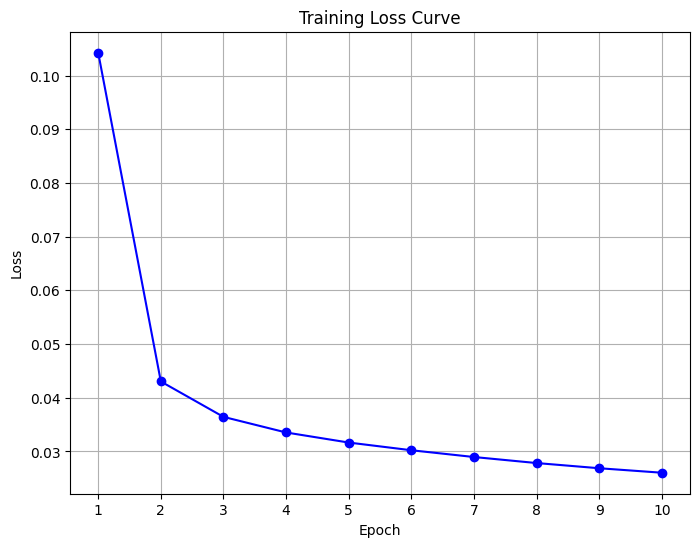

In [57]:
def plot_loss_curve(loss_list):
    """
    Plots the loss curve given a list of loss values.
    
    Parameters:
        loss_list (list of floats): The list containing the loss values after each epoch.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(loss_list) + 1), loss_list, marker='o', linestyle='-', color='blue')
    plt.title("Training Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.xticks(range(1, len(loss_list) + 1))
    plt.grid(True)
    plt.show()

# Plot the loss curve
plot_loss_curve(loss_list)


## 2.11 Find the Best Hyperparameters

Let us train the model for different values for our hyperparameters.

In [47]:
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5]
hidden_layer_sizes = [5,10,30]
epochs = 10

# results is dictionary mapping tuples of the form
# (learning_rate, hidden_layer_size) to tuples of the form
# (training_loss, test_loss).
results = {}
best_loss = 10   # The lowest test loss that we have seen so far.
best_model = None # The MLP object that achieved the lowest test loss.
best_loss_list = None  # The loss list for the best model
best_lr = None  # The learning rate for the best model
best_hl = None  # The hidden layer size for the best model

train_data, train_labels = data_preprocessing("train_data.csv")
test_data, test_labels = data_preprocessing("test_data.csv")

data = train_data.values.tolist()
labels = train_labels.tolist()
test_data = test_data.values.tolist()
test_labels = test_labels.tolist()

for lr in learning_rates:

    for hl in hidden_layer_sizes:

        # Create and train a new MLP instance
        mlp = MLP(input_size=input_size, hidden_size=hl, output_size=output_size)
        loss_list = egit(mlp, data, labels, epochs, lr)
        train_loss = loss_list[-1]

        # Predict values for test set and calculate test loss
        test_loss, test_accuracy = test(mlp, test_data, test_labels)

        print(f"learning rate={lr} and hidden layer size={hl} provided train_loss={train_loss:.3f} and test_loss={test_loss:.3f}")

        # Save the results
        results[(lr,hl)] = (train_loss, test_loss)
        if test_loss < best_loss:
            best_lr = lr
            best_hl = hl
            best_loss = test_loss
            best_model = mlp
            best_loss_list = loss_list

# best_model = mlp
# test_loss, test_accuracy = test(mlp, test_data, test_labels)

print(f'\nLowest test loss achieved: {best_model} with params hl={best_hl} and lr={best_lr}')

Test Loss: 0.05715960390068871
Test Accuracy: 82.038%
learning rate=0.01 and hidden layer size=5 provided train_loss=0.056 and test_loss=0.057
Test Loss: 0.041712625485869986
Test Accuracy: 88.079%
learning rate=0.01 and hidden layer size=10 provided train_loss=0.040 and test_loss=0.042
Test Loss: 0.03951758744754205
Test Accuracy: 88.569%
learning rate=0.01 and hidden layer size=30 provided train_loss=0.037 and test_loss=0.040
Test Loss: 0.19850720763034368
Test Accuracy: 43.404%
learning rate=0.001 and hidden layer size=5 provided train_loss=0.203 and test_loss=0.199
Test Loss: 0.18793229310244738
Test Accuracy: 51.345%
learning rate=0.001 and hidden layer size=10 provided train_loss=0.193 and test_loss=0.188
Test Loss: 0.16985782298196628
Test Accuracy: 67.617%
learning rate=0.001 and hidden layer size=30 provided train_loss=0.176 and test_loss=0.170
Test Loss: 0.23048341668753108
Test Accuracy: 12.131%
learning rate=0.0001 and hidden layer size=5 provided train_loss=0.231 and test_

## 2.12 Plot the Loss Curve of the Best Model

Let us analyze some aspects of the best model. To keep things short, let us just plot the loss history.

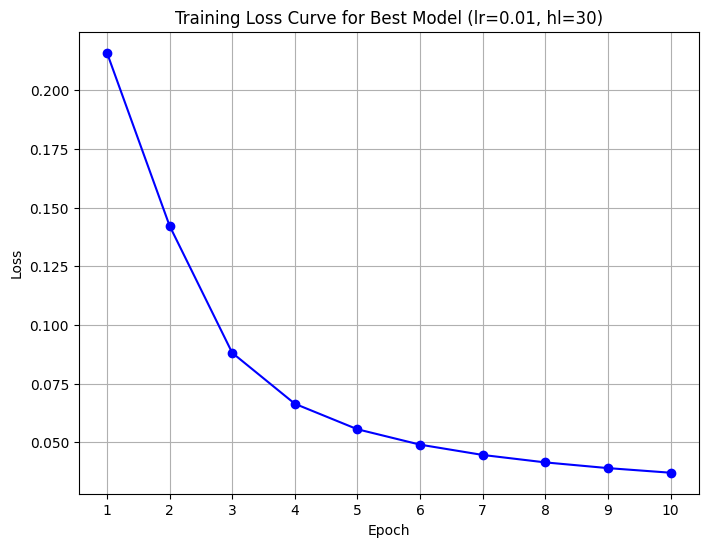

In [48]:
def plot_best_loss_curve(loss_list, best_lr, best_hl):
    """
    Plots the loss curve for the best model using the given loss history.

    Parameters:
        loss_list (list of floats): The list containing the loss values after each epoch for the best model.
        best_lr (float): The learning rate used for the best model.
        best_hl (int): The hidden layer size used for the best model.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(loss_list) + 1), loss_list, marker='o', linestyle='-', color='blue')
    plt.title(f"Training Loss Curve for Best Model (lr={best_lr}, hl={best_hl})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.xticks(range(1, len(loss_list) + 1))
    plt.grid(True)
    plt.show()

# Plot the loss curve for the best model
plot_best_loss_curve(best_loss_list, best_lr, best_hl)

# 3 Implementation in PyTorch

Now, you need to implement the same MLP structure using PyTorch library.

## 3.1 MLP_torch class

In [49]:
import torch
import torch.nn as nn

# Define the MLP architecture
class MLP_torch(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP_torch, self).__init__()
        self.hidden_layer = nn.Linear(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        """
        Forward pass of the MLP
        
        Parameters:
            x (torch.Tensor): Input tensor
        
        Returns:
            torch.Tensor: Output tensor
        """
        x = torch.relu(self.hidden_layer(x))
        x = torch.softmax(self.output_layer(x), dim=1)
        return x

## 3.2 Data Preprocessing

In [50]:
def data_preprocessing_torch(file_path):
    # Preprocess the dataset
    df = pd.read_csv(file_path)
    labels = df.iloc[:, 0]
    features = df.iloc[:, 1:]

    # One-hot encode the labels for classification
    lb = LabelBinarizer()
    one_hot_labels = lb.fit_transform(labels)

    # Convert data to PyTorch tensors
    data_tensor = torch.tensor(features.values, dtype=torch.float32) / 255  # Normalize pixel values
    label_tensor = torch.tensor(one_hot_labels, dtype=torch.float32)

    return data_tensor, label_tensor

# Load the data
# train_data_path = "train_data.csv"
# data_preprocessing_torch(train_data_path)

## 3.3 Training Pipeline

In [51]:
import torch.optim as optim

def train_torch(mlp, inputs, targets, epochs, learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(mlp.parameters(), lr=learning_rate)
    loss_curve = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        epoch_loss = 0
        # Forward pass - with mlp.forward
        outs = mlp.forward(inputs)
        # Calculate Loss - with criterion (CrossEntropyLoss)
        loss = criterion(outs, targets) / 10 # Hidden size
        epoch_loss += loss.item()
        # Backward pass - Compute gradients for example
        loss.backward()
        optimizer.step()
        # Print epoch loss here if desired
        print(f'EPOCH: {epoch}, Loss: {epoch_loss}')
        loss_curve.append(epoch_loss)

    return loss_curve

# # Load the data
# train_data_path = "train_data.csv"
# test_data_path = "test_data.csv"
# train_data, train_labels = data_preprocessing_torch(train_data_path)
# test_data, test_labels = data_preprocessing_torch(test_data_path)

# # Initialize the MLP with input, hidden, and output layers
# input_size = 28 * 28
# hidden_size = 10
# output_size = 10
# mlp_torch = MLP_torch(input_size, hidden_size, output_size)

# # Train the MLP using PyTorch
# epochs = 100
# learning_rate = 0.1
# list = train_torch(mlp_torch, train_data, train_labels, epochs, learning_rate)



## 3.4 Testing Pipeline

In [52]:
def test_torch(mlp, inputs, targets):
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        outputs = mlp(inputs)
        _, targets_indices = torch.max(targets, 1)
        loss = criterion(outputs, targets_indices)
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == targets_indices).sum().item()
        accuracy = correct / len(inputs)

    print(f"Test Loss: {loss.item()}")
    print(f"Test Accuracy: {accuracy * 100:.3f}%")

    return loss.item(), accuracy

## 3.5 Main code for PyTorch implementation

In [53]:
# Load the data
train_data_path = "train_data.csv"
test_data_path = "test_data.csv"
train_data, train_labels = data_preprocessing_torch(train_data_path)
test_data, test_labels = data_preprocessing_torch(test_data_path)

# Initialize the MLP with input, hidden, and output layers
input_size = 28 * 28
hidden_size = 30
output_size = 10
mlp_torch = MLP_torch(input_size, hidden_size, output_size)

# Train the PyTorch model
epochs = 100
learning_rate = 0.01
train_torch(mlp_torch, train_data, train_labels, epochs, learning_rate)

# Test the PyTorch model
test_loss, test_accuracy = test_torch(mlp_torch, test_data, test_labels)


EPOCH: 0, Loss: 0.23024067282676697
EPOCH: 1, Loss: 0.22744961082935333
EPOCH: 2, Loss: 0.22149555385112762
EPOCH: 3, Loss: 0.21462073922157288
EPOCH: 4, Loss: 0.20714084804058075
EPOCH: 5, Loss: 0.20021584630012512
EPOCH: 6, Loss: 0.19451218843460083
EPOCH: 7, Loss: 0.1900450736284256
EPOCH: 8, Loss: 0.1864955723285675
EPOCH: 9, Loss: 0.18396608531475067
EPOCH: 10, Loss: 0.18169744312763214
EPOCH: 11, Loss: 0.17893081903457642
EPOCH: 12, Loss: 0.1766240894794464
EPOCH: 13, Loss: 0.17480109632015228
EPOCH: 14, Loss: 0.17362555861473083
EPOCH: 15, Loss: 0.17283916473388672
EPOCH: 16, Loss: 0.17150233685970306
EPOCH: 17, Loss: 0.1705017387866974
EPOCH: 18, Loss: 0.16980648040771484
EPOCH: 19, Loss: 0.1691531389951706
EPOCH: 20, Loss: 0.16848944127559662
EPOCH: 21, Loss: 0.16781993210315704
EPOCH: 22, Loss: 0.16727712750434875
EPOCH: 23, Loss: 0.16689318418502808
EPOCH: 24, Loss: 0.16650453209877014
EPOCH: 25, Loss: 0.16607950627803802
EPOCH: 26, Loss: 0.1657426506280899
EPOCH: 27, Loss: 